In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# read the data
df=pd.read_csv('gdrive/My Drive/Colab Notebooks/Part 2/heart.csv')#,sep="|")
#df = pd.read_csv('data_third_class.csv')
print(df.head())

   age  sex  cp  trestbps  chol  fbs  ...  exang  oldpeak  slope  ca  thal  target
0   63    1   3       145   233    1  ...      0      2.3      0   0     1       1
1   37    1   2       130   250    0  ...      0      3.5      0   0     2       1
2   41    0   1       130   204    0  ...      0      1.4      2   0     2       1
3   56    1   1       120   236    0  ...      0      0.8      2   0     2       1
4   57    0   0       120   354    0  ...      1      0.6      2   0     2       1

[5 rows x 14 columns]


In [ ]:
x=df.drop(columns=['target'])
y=df['target']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
class network():
  def __init__(self, X, X_Validation, Y, Y_Validation, learning_rate, n_hidden, n_iters=1000, device='cpu'):
    self.device = device
    self.X = X
    self.X_Validation = X_Validation
    self.Y = Y.to_numpy().reshape(-1, 1)
    self.Y_t = torch.FloatTensor(self.Y).to(device=self.device)
    self.Y_Validation = Y_Validation.to_numpy().reshape(-1, 1)
    self.Y_Validation_t = torch.FloatTensor(self.Y_Validation).to(device=self.device)
    self.n_input_dim = X.shape[1]
    self.n_output = 1
    self.learning_rate = learning_rate
    self.n_hidden = n_hidden
    self.n_iters = n_iters

    # Build network
    torch.manual_seed(50)
    self.net = nn.Sequential(
      nn.Linear(self.n_input_dim, self.n_hidden),
      nn.ReLU(),   
      nn.Linear(self.n_hidden, self.n_hidden),
      nn.ReLU(),   
      nn.Linear(self.n_hidden, self.n_output),
      nn.Sigmoid())

    if self.device == 'cuda':
      self.net.cuda()

    self.loss_func = nn.BCELoss()
    self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)

  def predict(self, X):
    # Function to generate predictions based on data
    X_t = torch.FloatTensor(X.to_numpy()).to(device=self.device)
    return self.net(X_t)

  def predict_test(self, X):
    # Function to generate predictions based on data
    X_t = torch.FloatTensor(X.to_numpy()).to(device=self.device)
    self.net.eval()
    with torch.no_grad():
        test_pred = self.net(X_t)
    return test_pred

  def calculate_loss(self, y_hat):
    return self.loss_func(y_hat, self.Y_t)

  def calculate_test_loss(self, y_hat):
    return self.loss_func(y_hat, self.Y_Validation_t)

  def update_network(self, y_hat):
    self.optimizer.zero_grad()
    loss = self.calculate_loss(y_hat)
    loss.backward()
    self.optimizer.step()
    self.training_loss.append(loss.item())

  def calculate_accuracy(self, y_hat_class, Y):
      return np.sum(Y.reshape(-1, 1) == y_hat_class) / len(Y)
  
  def calculate_auc(self,pred, y):
      pred_class = np.where(pred.detach().numpy() < 0.5, 0, 1)
      fpr, tpr, thresholds = roc_curve(y, pred_class)
      return auc(fpr, tpr)
  
  def calculate_test_accuracy(self, X_Test, Y_Test):
    y_hat_test = self.predict_test(X_Test)
    y_hat_test_class = np.where(y_hat_test < 0.5, 0, 1)
    test_accuracy = self.calculate_accuracy(y_hat_test_class, Y_Test)
    return test_accuracy

  def train(self):
    self.training_loss = []
    self.training_accuracy = []
    self.validation_accuracy=[]
    self.train_auc = []
    self.test_auc = []
    self.validation_loss = []
    self.tr_auc=[]
    self.val_auc=[]
    
    prev_val_accuracy=-1
    negative_val_improvment_counter=0
    for i in range(self.n_iters):
      y_hat = self.predict(self.X)
      y_hat_validation = self.predict_test(self.X_Validation)
      self.update_network(y_hat)
      self.validation_loss.append(self.calculate_test_loss(y_hat_validation).item())

      y_hat_class = np.where(y_hat < 0.5, 0, 1)
      accuracy = self.calculate_accuracy(y_hat_class, self.Y)
      self.training_accuracy.append(accuracy)
      
      y_hat_validation_class = np.where(y_hat_validation < 0.5, 0, 1)
      val_accuracy = self.calculate_accuracy(y_hat_validation_class, self.Y_Validation)
      self.validation_accuracy.append(val_accuracy)

      lr_auc_2 = self.calculate_auc(y_hat, self.Y)
      lr_auc_test_2 = self.calculate_auc(y_hat_validation, self.Y_Validation)
      self.tr_auc.append(lr_auc_2)
      self.val_auc.append(lr_auc_test_2)

      if val_accuracy<=prev_val_accuracy:
        negative_val_improvment_counter+=1
      else:
        negative_val_improvment_counter=0
      prev_val_accuracy=val_accuracy
      if i>800 and negative_val_improvment_counter==5:
        self.n_iters=i+1
        break;

      #if i>0 and i%10==0:
        #print(f'epoch #{i} - training loss is {round(self.training_loss[i],5)} - validation loss is {round(self.validation_loss[i],5)}')

  def plot_graph(self, data, title, x_label, y_label):
    epochs = range(0, self.n_iters)
    plt.plot(epochs, data)
    plt.ylabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.tight_layout()
    plt.show()
      
      
  def plot_train_and_test_loss(self):
    plt.plot(range(0, self.n_iters), self.training_loss,color='red', label="train")
    plt.plot(range(0, self.n_iters), self.validation_loss, label="validation")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.title('Train vs. Validation Loss')
    plt.legend()
    plt.show()
    

    plt.plot(range(0, self.n_iters), self.training_accuracy,color='red', label="train")
    plt.plot(range(0, self.n_iters), self.validation_accuracy, label="validation")
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.title('Train vs. Validation accuracy')
    plt.legend()
    print("Train Accuracy {:.2f}%".format(self.training_accuracy[-1]*100))
    print("Validation Accuracy {:.2f}%".format(self.validation_accuracy[-1]*100))
    plt.show()
    
    #self.plot_graph(self.training_accuracy, 'Training Accuracy', 'Epochs', 'Classification Accuracy')
    #print("Train Accuracy {:.2f}%".format(self.training_accuracy[-1]*100))
    #plt.show()
      
  def plot_train_and_test_AUC(self):
    print("Train AUC {:.2f}".format(self.tr_auc[-1]))
    print("Validation AUC {:.2f}".format(self.val_auc[-1]))
    plt.plot(range(0, self.n_iters), self.tr_auc,color='red', label="train")
    plt.plot(range(0, self.n_iters), self.val_auc, label="validation")
    
    plt.xlabel("epochs")
    plt.ylabel("AUC")
    plt.title('Train vs. Validation AUC')
    plt.legend();
    plt.show()

In [ ]:
def chooseEpisodeData(x_train, y_train, n_train, n_validate):
  x_train_episode=[]
  y_train_episode=[]
  x_validation_episode=[]
  y_validation_episode=[]
  used_indices=[]
  while len(x_train_episode)<n_train:
    i=-1
    while i<0 or (i in used_indices):
      i=random.randint(0,len(x_train)-1)
    x_train_episode.append(x_train.iloc[i])
    y_train_episode.append(y_train.iloc[i])
    used_indices.append(i)
  
  for i in range(len(x_train)):
    if len(x_validation_episode)<n_validate and i not in used_indices:
      x_validation_episode.append(x_train.iloc[i])
      y_validation_episode.append(y_train.iloc[i])
  
  return x_train_episode, y_train_episode, x_validation_episode, y_validation_episode

In [ ]:
def getExplorationP(i, iterations):
  if i<iterations/4:
    return 0.1
  if i<iterations/2:
    return 0.05
  if i<iterations*0.75:
    return 0.01
  return 0.005

In [ ]:
def getAlpha(i, iterations):
  if i<iterations/4:
    return 0.9
  if i<iterations/2:
    return 0.5
  if i<iterations*0.75:
    return 0.3
  return 0.1

In [ ]:
def get_best_next_feature(current_state, Q_arr, available_features, feature_to_Index_dict):
  #max_indices=[]
  max_index=-1
  maxQ=-1000
  for i in range(len(available_features)):
    next_feature=available_features[i]
    if next_feature!=current_state:
      next_feature_Q_score=Q_arr[feature_to_Index_dict[current_state]][feature_to_Index_dict[next_feature]]
      #print(f'next_feature: {next_feature}, Q score: {next_feature_Q_score}')
      if maxQ<next_feature_Q_score:
        if maxQ<Q_arr[feature_to_Index_dict[current_state]][feature_to_Index_dict[next_feature]]:
          #max_indices=[]
          max_index=i
          maxQ=Q_arr[feature_to_Index_dict[current_state]][feature_to_Index_dict[next_feature]]
        #max_indices.append(i)
  #print (f'max_indices: {max_indices}')
  return max_index
  #return max_indices[random.randint(0,len(max_indices)-1)]

In [ ]:
def calc_updated_Q(current_state, next_state, Q_arr, reward, alpha, discount_factor, features_list, feature_to_Index_dict):
  current_state_index=feature_to_Index_dict[current_state]
  next_state_index=feature_to_Index_dict[next_state]

  current_state_next_state_Q=Q_arr[current_state_index][next_state_index]
  best_next_state_Q_index=get_best_next_feature(current_state, Q_arr, features_list, feature_to_Index_dict)
  Q_arr[current_state_index][next_state_index]=current_state_next_state_Q+alpha*(reward+discount_factor*Q_arr[current_state_index][best_next_state_Q_index]-current_state_next_state_Q)

In [ ]:
def find_best_path(Q_arr,features_list,feature_to_Index_dict):
  available_features=features_list[:]
  best_features=[]
  current_state='zero'
  current_state_index=feature_to_Index_dict[current_state]
  next_state=-1
  counter=0
  while next_state==-1 or len(best_features)<=len(features_list):
    next_state_features_arr_index=get_best_next_feature(current_state, Q_arr, available_features, feature_to_Index_dict)
    next_state=available_features[next_state_features_arr_index]
    #print(f'current state: {current_state}, best next state: {next_state}')
    next_state_index=feature_to_Index_dict[next_state]
    #print(f'next state reward: {Q_arr[current_state_index][next_state_index]}')
    if Q_arr[current_state_index][next_state_index]>0:
      best_features.append(available_features.pop(next_state_features_arr_index))
      current_state=next_state
      current_state_index=feature_to_Index_dict[current_state]
    else:
      break
    counter+=1
    if counter>20:
      break
  
  return best_features
  #print(f'best features: {best_features}')

In [ ]:
def calc_test_accuracy_for_best_features(Q_arr,features_list,feature_to_Index_dict):
  best_features=find_best_path(Q_arr,features_list,feature_to_Index_dict)
  print(f'best features: {best_features}')
  if len(best_features)==0:
    return 0
  best_features_x_train = pd.DataFrame(x_train_all, columns = best_features)
  best_features_x_validation = pd.DataFrame(x_validation_all, columns = best_features)
  best_features_x_test=pd.DataFrame(x_test, columns = best_features)

  bestFeaturesHeartNet=network(best_features_x_train, best_features_x_validation, pd.DataFrame(y_train_all), pd.DataFrame(y_validation_all), n_iters=50, n_hidden=4, learning_rate=0.02)
  bestFeaturesHeartNet.train()
  best_features_test_accuracy=bestFeaturesHeartNet.calculate_test_accuracy(best_features_x_test,y_test.to_numpy())
  print(f'test accuracy best features: {best_features_test_accuracy}')
  return best_features_test_accuracy

In [ ]:
x_train_all, x_validation_all, y_train_all, y_validation_all = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [ ]:
print(f'all features: {features_list}')

all features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [ ]:
random.seed(10)

features_list=x_train.columns.tolist()

feature_to_Index_dict={}
feature_to_Index_dict['zero']=0
for i in range(len(features_list)):
  feature_to_Index_dict[features_list[i]]=i+1

discount_factor=0.9
Q_arr=np.zeros([14,14])
n_episode=100
n_train=80
iterations=round(20*len(x_train)/n_episode)
bestPathTestAccuracy=[]
bestPathLength=[]
sum_reward_by_episode=[]
for iter in range(iterations):
  print(f'started iteration #{iter} of {iterations} iterations')
  x_train_episode, y_train_episode, x_validation_episode, y_validation_episode=chooseEpisodeData(x_train,y_train,80,20)
  last_accuracy=0.5
  current_state='zero'
  current_features=[]
  available_features=features_list[:]
  exploration_p=getExplorationP(iter, iterations)
  #print(f'exploration_p: {exploration_p}')
  alpha=getAlpha(iter, iterations)
  reward_sum=0
  while len(current_features)<len(features_list):
    next_state=''
    if random.random()<0.9:#exploration_p:
      #print(f'exploration ***************************************************')
      next_state=available_features.pop(random.randint(0,len(available_features)-1))
    else:
      next_state_index=get_best_next_feature(current_state, Q_arr, available_features, feature_to_Index_dict)
      next_best_reward=Q_arr[feature_to_Index_dict[current_state]][next_state_index]
      if next_best_reward<0:
        break
      next_state=available_features.pop(next_state_index)

    current_features.append(next_state)
    episode_specific_features_x_train = pd.DataFrame(x_train_episode, columns = current_features)
    episode_specific_features_x_validation = pd.DataFrame(x_validation_episode, columns = current_features)
    heartNet = network(episode_specific_features_x_train, episode_specific_features_x_validation, pd.DataFrame(y_train_episode), pd.DataFrame(y_validation_episode), n_iters=50, n_hidden=4, learning_rate=0.02)
    heartNet.train()
    
    val_accuracy=heartNet.calculate_test_accuracy(episode_specific_features_x_validation,pd.DataFrame(y_validation_episode).to_numpy())
    #print(f'validation accuracy: {val_accuracy}\n')
    
    reward=val_accuracy-last_accuracy
    reward_sum+=reward
    calc_updated_Q(current_state, next_state, Q_arr, reward, alpha, discount_factor, features_list, feature_to_Index_dict)
    
    last_accuracy=val_accuracy
    current_state=next_state
  
  sum_reward_by_episode.append(reward_sum)
  bestPathLength.append(len(find_best_path(Q_arr,features_list,feature_to_Index_dict)))
  best_features_test_accuracy=calc_test_accuracy_for_best_features(Q_arr,features_list,feature_to_Index_dict)
  random_features_test_accuracy = calc_test_accuracy_for_best_features(Q_arr,random_list,feature_to_Index_dict)
  bestPathTestAccuracy.append(best_features_test_accuracy)
#print(Q_arr)

started iteration #0 of 48 iterations
best features: []
started iteration #1 of 48 iterations
best features: []
started iteration #2 of 48 iterations
best features: ['fbs', 'sex', 'cp']
test accuracy best features: 0.8360655737704918
started iteration #3 of 48 iterations
best features: ['fbs', 'sex', 'cp']
test accuracy best features: 0.8360655737704918
started iteration #4 of 48 iterations
best features: ['fbs', 'cp', 'thal', 'thalach']
test accuracy best features: 0.5245901639344263
started iteration #5 of 48 iterations
best features: ['exang', 'oldpeak']
test accuracy best features: 0.5245901639344263
started iteration #6 of 48 iterations
best features: ['exang', 'oldpeak']
test accuracy best features: 0.5245901639344263
started iteration #7 of 48 iterations
best features: ['cp', 'thal', 'thalach', 'age', 'oldpeak']
test accuracy best features: 0.5245901639344263
started iteration #8 of 48 iterations
best features: ['cp', 'thal', 'thalach', 'age', 'oldpeak', 'trestbps', 'fbs', 'sex'

In [ ]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
#print(pd.DataFrame(Q_arr))
display(pd.DataFrame(Q_arr))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,0.007050,0.033750,-5.694625e-02,0.048500,0.047369,0.047682,0.000000,0.113242,0.140505,0.202526,0.102800,0.032645,0.104258
1,0.0,0.000000,0.045000,-1.292250e-01,0.000000,0.005000,0.000000,-0.043625,0.000000,0.000000,0.207250,0.000000,0.022050,0.000000
2,0.0,-0.112500,0.000000,-1.386375e-01,-0.174390,-0.161550,-0.295650,-0.026543,-0.282150,0.009850,-0.128206,-0.327236,-0.106775,-0.094095
3,0.0,0.000000,0.157257,0.000000e+00,-0.118125,-0.109350,-0.023625,0.000000,0.097500,0.000000,0.062500,0.068700,0.000000,0.099611
4,0.0,-0.111799,0.000000,0.000000e+00,0.000000,0.000000,0.116774,0.025515,0.055044,0.026169,-0.226800,-0.016074,-0.105000,-0.047500
5,0.0,-0.020700,0.000000,-1.942890e-17,-0.009950,0.000000,0.000000,0.000000,0.039195,0.000000,-0.048007,-0.120285,-0.055000,0.061335
6,0.0,0.088721,0.013500,-6.104550e-02,0.000000,-0.070612,0.000000,0.005000,0.125689,-0.039510,0.090000,-0.089360,0.032245,-0.020019
7,0.0,-0.060525,-0.048050,0.000000e+00,0.000000,-0.022050,0.015000,0.000000,-0.200000,0.005000,0.012500,0.010000,0.019647,-0.045000
8,0.0,0.033412,0.034507,5.713537e-03,0.005714,-0.148388,0.023007,-0.128800,0.000000,0.003007,0.015714,0.026160,0.000000,0.000000
9,0.0,-0.023350,0.027322,4.500000e-03,0.002500,0.020000,0.019845,0.020463,-0.002025,0.000000,0.080452,-0.068425,-0.045000,0.055350


In [ ]:
print(f'best path: {find_best_path(Q_arr,features_list,feature_to_Index_dict)}')
print(f'best path size: {len(find_best_path(Q_arr,features_list,feature_to_Index_dict))}')

best path: ['oldpeak', 'cp', 'sex', 'exang', 'thal']
best path size: 5


In [ ]:
x_train_all, x_validation_all, y_train_all, y_validation_all = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

allFeaturesHeartNet=network(x_train_all, x_validation_all, pd.DataFrame(y_train_all), pd.DataFrame(y_validation_all), n_iters=50, n_hidden=4, learning_rate=0.02)
allFeaturesHeartNet.train()
y_test_t=torch.FloatTensor(y_test.to_numpy().reshape(-1, 1))
all_features_test_accuracy=allFeaturesHeartNet.calculate_test_accuracy(x_test,y_test.to_numpy())
print(f'test accuracy all features: {all_features_test_accuracy}')

best_features=find_best_path(Q_arr,features_list,feature_to_Index_dict)
print(f'best features: {best_features}')
best_features_x_train = pd.DataFrame(x_train_all, columns = best_features)
best_features_x_validation = pd.DataFrame(x_validation_all, columns = best_features)
best_features_x_test=pd.DataFrame(x_test, columns = best_features)

bestFeaturesHeartNet=network(best_features_x_train, best_features_x_validation, pd.DataFrame(y_train_all), pd.DataFrame(y_validation_all), n_iters=50, n_hidden=4, learning_rate=0.02)
bestFeaturesHeartNet.train()
y_test_t=torch.FloatTensor(y_test.to_numpy().reshape(-1, 1))
best_features_test_accuracy=bestFeaturesHeartNet.calculate_test_accuracy(best_features_x_test,y_test.to_numpy())
print(f'test accuracy best features: {best_features_test_accuracy}')

random_features=[]
for i in range(5):
  random_features.append(features_list[i])
print(f'random features: {random_features}')

random_features_x_train = pd.DataFrame(x_train_all, columns = random_features)
random_features_x_validation = pd.DataFrame(x_validation_all, columns = random_features)
random_features_x_test=pd.DataFrame(x_test, columns = random_features)

randomFeaturesHeartNet=network(random_features_x_train, random_features_x_validation, pd.DataFrame(y_train_all), pd.DataFrame(y_validation_all), n_iters=50, n_hidden=4, learning_rate=0.02)
randomFeaturesHeartNet.train()
y_test_t=torch.FloatTensor(y_test.to_numpy().reshape(-1, 1))
random_features_test_accuracy=randomFeaturesHeartNet.calculate_test_accuracy(random_features_x_test,y_test.to_numpy())
print(f'test accuracy random features: {random_features_test_accuracy}')


test accuracy all features: 0.8688524590163934
best features: ['oldpeak', 'cp', 'sex', 'exang', 'thal']
test accuracy best features: 0.8524590163934426
random features: ['age', 'sex', 'cp', 'trestbps', 'chol']
test accuracy random features: 0.5245901639344263


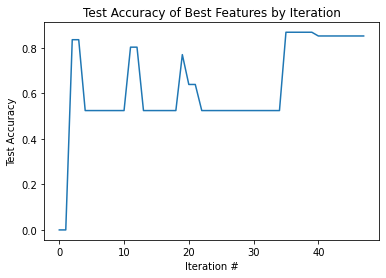

In [ ]:
plt.plot(range(iterations), bestPathTestAccuracy)
plt.xlabel("Iteration #")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy of Best Features by Iteration")
plt.show()

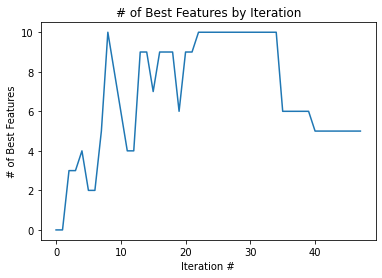

In [ ]:
plt.plot(range(iterations), bestPathLength)
plt.xlabel("Iteration #")
plt.ylabel("# of Best Features")
plt.title("# of Best Features by Iteration")
plt.show()

best features: ['oldpeak', 'cp', 'sex', 'exang', 'thal']
test accuracy best features (['oldpeak']): 0.6885245901639344
test accuracy best features (['oldpeak', 'cp']): 0.819672131147541
test accuracy best features (['oldpeak', 'cp', 'sex']): 0.8360655737704918
test accuracy best features (['oldpeak', 'cp', 'sex', 'exang']): 0.7868852459016393
test accuracy best features (['oldpeak', 'cp', 'sex', 'exang', 'thal']): 0.8524590163934426


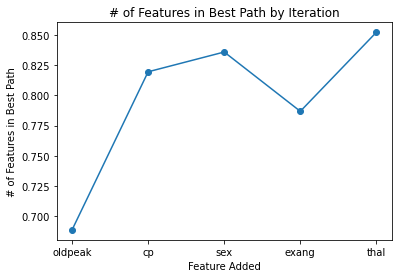

In [ ]:
best_features=find_best_path(Q_arr,features_list,feature_to_Index_dict)
print(f'best features: {best_features}')
current_best_features=[]
test_accuracy_by_feature_stepwise=[]
for i in range(len(best_features)):
  current_best_features.append(best_features[i])
  best_features_x_train = pd.DataFrame(x_train_all, columns = current_best_features)
  best_features_x_validation = pd.DataFrame(x_validation_all, columns = current_best_features)
  best_features_x_test=pd.DataFrame(x_test, columns = current_best_features)

  bestFeaturesHeartNet=network(best_features_x_train, best_features_x_validation, pd.DataFrame(y_train_all), pd.DataFrame(y_validation_all), n_iters=50, n_hidden=4, learning_rate=0.02)
  bestFeaturesHeartNet.train()
  best_features_test_accuracy=bestFeaturesHeartNet.calculate_test_accuracy(best_features_x_test,y_test.to_numpy())
  print(f'test accuracy best features ({current_best_features}): {best_features_test_accuracy}')
  test_accuracy_by_feature_stepwise.append(best_features_test_accuracy)

plt.plot(best_features, test_accuracy_by_feature_stepwise,marker='o')
plt.xlabel("Feature Added")
plt.ylabel("# of Features in Best Path")
plt.title("# of Features in Best Path by Iteration")
plt.show()

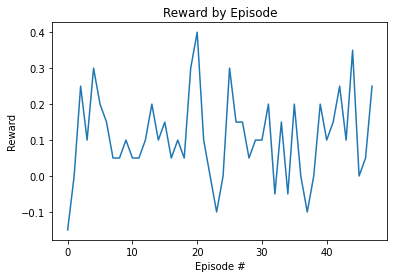

In [ ]:
plt.plot(range(len(sum_reward_by_episode)), sum_reward_by_episode)
plt.xlabel("Episode #")
plt.ylabel("Reward")
plt.title("Reward by Episode")
plt.show()